In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,DepthwiseConv2D,GlobalAveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
from tensorflow.keras.optimizers import Adam

In [2]:
BASE_PATH = '/kaggle/input/skin-cancer-mnist-ham10000/'
IMG_HEIGHT, IMG_WIDTH = 200, 150

In [3]:
metadata_path = os.path.join(BASE_PATH, 'HAM10000_metadata.csv')

In [4]:
def abs_path(x):
    if x +'.jpg' in os.listdir(os.path.join(BASE_PATH, 'HAM10000_images_part_1')):
        return os.path.join(BASE_PATH, 'HAM10000_images_part_1', x +'.jpg')
    elif x +'.jpg' in os.listdir(os.path.join(BASE_PATH, 'HAM10000_images_part_2')):
        return os.path.join(BASE_PATH, 'HAM10000_images_part_2', x +'.jpg')

In [5]:
metadata = pd.read_csv(metadata_path)
metadata['image_id'] = metadata['image_id'].apply(abs_path)
metadata

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,bkl,histo,80.0,male,scalp
1,HAM_0000118,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,bkl,histo,80.0,male,scalp
2,HAM_0002730,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,bkl,histo,80.0,male,scalp
3,HAM_0002730,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,bkl,histo,80.0,male,scalp
4,HAM_0001466,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,akiec,histo,80.0,male,face


In [6]:
metadata['binary_class'] = metadata['dx'].apply(lambda x: 'maligant' if x == 'mel' else 'benign')

In [7]:
print(metadata)

         lesion_id                                           image_id     dx  \
0      HAM_0000118  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...    bkl   
1      HAM_0000118  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...    bkl   
2      HAM_0002730  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...    bkl   
3      HAM_0002730  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...    bkl   
4      HAM_0001466  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...    bkl   
...            ...                                                ...    ...   
10010  HAM_0002867  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...  akiec   
10011  HAM_0002867  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...  akiec   
10012  HAM_0002867  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...  akiec   
10013  HAM_0000239  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...  akiec   
10014  HAM_0003521  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...    mel   

      dx_type   age     sex localizatio

In [9]:
import shutil
from PIL import Image, ImageOps

augmented_dir = "augmented_dataset"
melanoma_aug_dir = os.path.join(augmented_dir, "melanoma")
os.makedirs(melanoma_aug_dir, exist_ok=True)

melanoma_images = metadata[metadata['binary_class'] == 'maligant']['image_id'].tolist()

print(f"Number of melanoma images: {len(melanoma_images)}")


def apply_augmentations(img, base_name):
    augmentations = [
        ("rot_90", img.rotate(90)),
        ("rot_180", img.rotate(180)),
        ("rot_270", img.rotate(270)),
        ("rot_90_flip", ImageOps.mirror(img.rotate(90))),
        ("rot_180_flip", ImageOps.flip(img.rotate(180))),
        ("rot_270_flip", ImageOps.mirror(img.rotate(270)))
    ]
    
    for suffix, aug_img in augmentations:
        aug_img.save(os.path.join(melanoma_aug_dir, f"{base_name}_{suffix}.jpg"))

print("Generating augmented images for melanoma...")
augmented_images = 0
for img_path in melanoma_images:
    img = Image.open(img_path).convert("RGB")
    base_name = os.path.basename(img_path).split('.')[0]
    
    img.save(os.path.join(melanoma_aug_dir, f"{base_name}_original.jpg"))
    
    apply_augmentations(img, base_name)
    augmented_images += 7
original_melanoma_count = len(melanoma_images)
augmented_melanoma_count = augmented_images
total_melanoma_images = original_melanoma_count + augmented_melanoma_count

print(f"Original melanoma images: {original_melanoma_count}")
print(f"Augmented melanoma images: {augmented_melanoma_count}")
print(f"Total melanoma images: {total_melanoma_images}")

Number of melanoma images: 1113
Generating augmented images for melanoma...
Original melanoma images: 1113
Augmented melanoma images: 7791
Total melanoma images: 8904


In [10]:
import shutil
from PIL import Image, ImageOps

augmented_dir = "augmented_dataset"
melanoma_aug_dir = os.path.join(augmented_dir, "maligant")
os.makedirs(melanoma_aug_dir, exist_ok=True)

combined_dir = "combined_dataset"
os.makedirs(os.path.join(combined_dir, "benign"), exist_ok=True)
os.makedirs(os.path.join(combined_dir, "maligant"), exist_ok=True)

benign_images = metadata[metadata['binary_class'] == 'benign']['image_id'].tolist()
melanoma_images = metadata[metadata['binary_class'] == 'maligant']['image_id'].tolist()

def apply_augmentations(img, base_name):
    augmentations = [
        ("rot_90", img.rotate(90)),
        ("rot_180", img.rotate(180)),
        ("rot_270", img.rotate(270)),
        ("flip_horizontal", ImageOps.mirror(img)),
        ("flip_vertical", ImageOps.flip(img)),
        ("rot_90_flip", ImageOps.mirror(img.rotate(90))),
        ("rot_180_flip", ImageOps.flip(img.rotate(180))),
        ("rot_270_flip", ImageOps.mirror(img.rotate(270)))
    ]
    augmented_images = []
    for suffix, aug_img in augmentations:
        augmented_image_path = os.path.join(melanoma_aug_dir, f"{base_name}_{suffix}.jpg")
        aug_img.save(augmented_image_path)
        augmented_images.append(augmented_image_path)
    
    return augmented_images

In [11]:
apply_augmentations

<function __main__.apply_augmentations(img, base_name)>

In [16]:
augmented_images = 0
for img_path in melanoma_images:
    img = Image.open(img_path).convert("RGB")
    base_name = os.path.basename(img_path).split('.')[0]
    
    original_image_path = os.path.join(melanoma_aug_dir, f"{base_name}_original.jpg")
    if not os.path.exists(original_image_path):
        img.save(original_image_path)
        augmented_images += 1
    
    augmentations = apply_augmentations(img, base_name)
    augmented_images += len(augmentations)
original_melanoma_count = len(melanoma_images)#1113
augmented_melanoma_count = augmented_images - original_melanoma_count#7791
total_melanoma_images = augmented_melanoma_count + original_melanoma_count#8904

print(augmented_melanoma_count)
print(total_melanoma_images)

7791
8904


In [17]:
for img_path in benign_images:
    base_name = os.path.basename(img_path)
    dest_path = os.path.join(combined_dir, "benign", base_name)
    shutil.copy(img_path, dest_path)

print(f"Moving augmented melanoma images to {combined_dir}/maligant...")

copied_files = []

for img_path in os.listdir(melanoma_aug_dir):
    base_name = os.path.basename(img_path)
    dest_path = os.path.join(combined_dir, "maligant", img_path)
    if base_name not in copied_files:
        shutil.copy(os.path.join(melanoma_aug_dir, img_path), dest_path)
        copied_files.append(base_name)
    else:
        print(f"Skipping duplicate: {base_name}")

Moving augmented melanoma images to combined_dataset/maligant...


In [18]:
benign_count = len(os.listdir(os.path.join(combined_dir, 'benign')))
maligant_count = len(os.listdir(os.path.join(combined_dir, 'maligant')))

print(f"Combined dataset class counts:")
print(f"Benign images: {benign_count}")
print(f"Maligant images: {maligant_count}")

assert maligant_count == total_melanoma_images , \
    f"Mismatch in the number of maligant images. Expected {total_melanoma_images }, but got {maligant_count}"



Combined dataset class counts:
Benign images: 8902
Maligant images: 10017


AssertionError: Mismatch in the number of maligant images. Expected 8904, but got 10017

In [19]:

if maligant_count > total_melanoma_images:
    extra_files = os.listdir(os.path.join(combined_dir, 'maligant'))
    extra_files_count = maligant_count - total_melanoma_images
    print(f"Found {extra_files_count} extra files. Removing them...")

    for extra_file in extra_files[:extra_files_count]:
        extra_file_path = os.path.join(combined_dir, 'maligant', extra_file)
        os.remove(extra_file_path)
        print(f"Removed: {extra_file}")

    final_maligant_count = len(os.listdir(os.path.join(combined_dir, 'maligant')))
    print(f"Final maligant count: {final_maligant_count}")

    assert final_maligant_count == augmented_melanoma_count, \
        f"Final count mismatch. Expected {augmented_melanoma_count }, but got {final_maligant_count}"


Found 1113 extra files. Removing them...
Removed: ISIC_0028041_rot_90.jpg
Removed: ISIC_0032695_flip_horizontal.jpg
Removed: ISIC_0030106_rot_90_flip.jpg
Removed: ISIC_0032936_rot_180_flip.jpg
Removed: ISIC_0024864_flip_horizontal.jpg
Removed: ISIC_0031025_rot_90_flip.jpg
Removed: ISIC_0032716_rot_90.jpg
Removed: ISIC_0032526_flip_vertical.jpg
Removed: ISIC_0031718_rot_270.jpg
Removed: ISIC_0032248_original.jpg
Removed: ISIC_0033881_rot_270_flip.jpg
Removed: ISIC_0028567_rot_270_flip.jpg
Removed: ISIC_0031550_rot_90.jpg
Removed: ISIC_0027260_rot_270.jpg
Removed: ISIC_0030795_rot_90_flip.jpg
Removed: ISIC_0032862_flip_horizontal.jpg
Removed: ISIC_0027190_rot_90_flip.jpg
Removed: ISIC_0033114_flip_vertical.jpg
Removed: ISIC_0032766_rot_90.jpg
Removed: ISIC_0032790_rot_180.jpg
Removed: ISIC_0032723_rot_270_flip.jpg
Removed: ISIC_0032856_rot_180.jpg
Removed: ISIC_0032517_rot_180.jpg
Removed: ISIC_0032645_rot_180.jpg
Removed: ISIC_0027234_rot_90_flip.jpg
Removed: ISIC_0024930_rot_180.jpg
Re

AssertionError: Final count mismatch. Expected 7791, but got 8904

In [20]:
combined_dir = "combined_dataset"
benign_dir = os.path.join(combined_dir, "benign")
maligant_dir = os.path.join(combined_dir, "maligant")

if not os.path.exists(benign_dir):
    print(f"Error: The directory '{benign_dir}' does not exist.")
else:
    benign_count = len([f for f in os.listdir(benign_dir) if f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.png')])  # Filter image files

if not os.path.exists(maligant_dir):
    print(f"Error: The directory '{maligant_dir}' does not exist.")
else:
    maligant_count = len([f for f in os.listdir(maligant_dir) if f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.png')])  # Filter image files

print(f"Overview of the combined dataset:")
print(f"Total benign images: {benign_count}")
print(f"Total malignant images: {maligant_count}")

if os.path.exists(benign_dir):
    benign_samples = [f for f in os.listdir(benign_dir) if f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.png')][:5]  # Preview first 5 benign images

if os.path.exists(maligant_dir):
    maligant_samples = [f for f in os.listdir(maligant_dir) if f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.png')][:5]  # Preview first 5 malignant images

print("\nSample benign images:")
print(benign_samples)

print("\nSample malignant images:")
print(maligant_samples)


Overview of the combined dataset:
Total benign images: 8902
Total malignant images: 8904

Sample benign images:
['ISIC_0027274.jpg', 'ISIC_0029197.jpg', 'ISIC_0026284.jpg', 'ISIC_0024379.jpg', 'ISIC_0033588.jpg']

Sample malignant images:
['ISIC_0033725_flip_horizontal.jpg', 'ISIC_0025573_flip_vertical.jpg', 'ISIC_0030129_original.jpg', 'ISIC_0026963_rot_180_flip.jpg', 'ISIC_0033299_rot_180.jpg']


In [21]:
from sklearn.model_selection import train_test_split

combined_dir = "combined_dataset"
benign_dir = os.path.join(combined_dir, "benign")
maligant_dir = os.path.join(combined_dir, "maligant")

benign_images = [os.path.join(benign_dir, f) for f in os.listdir(benign_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
maligant_images = [os.path.join(maligant_dir, f) for f in os.listdir(maligant_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

benign_labels = [0] * len(benign_images)
maligant_labels = [1] * len(maligant_images)

all_images = benign_images + maligant_images
all_labels = benign_labels + maligant_labels

In [22]:
X_train, X_temp, y_train, y_temp = train_test_split(all_images, all_labels, test_size=0.2, stratify=all_labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)

print(f"Training set class distribution: {dict(zip(*np.unique(y_train, return_counts=True)))}")
print(f"Validation set class distribution: {dict(zip(*np.unique(y_val, return_counts=True)))}")
print(f"Test set class distribution: {dict(zip(*np.unique(y_test, return_counts=True)))}")

Training set class distribution: {0: 7121, 1: 7123}
Validation set class distribution: {0: 890, 1: 891}
Test set class distribution: {0: 891, 1: 890}


In [23]:
# Define new test directory
test_dir = "test_images"
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)  # Remove existing directory
os.makedirs(test_dir)

# Create subdirectories for each class and move test images
for label in np.unique(y_test):
    class_dir = os.path.join(test_dir, str(label))
    os.makedirs(class_dir, exist_ok=True)

# Move test images to their respective class directories
for img_path, label in zip(X_test, y_test):
    shutil.copy(img_path, os.path.join(test_dir, str(label), os.path.basename(img_path)))

# Data Augmentation for Training and Validation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Generators
train_generator = train_datagen.flow_from_directory(
    combined_dir, 
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=200,
    class_mode="categorical",
    subset='training',  
)

validation_generator = train_datagen.flow_from_directory(
    combined_dir, 
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=200,
    class_mode="categorical",
    subset='validation',
)

# Load only test images
test_generator = test_datagen.flow_from_directory(
    test_dir,  # Now loading only test images
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=200,
    class_mode="categorical",
    shuffle=False
)


Found 14246 images belonging to 2 classes.
Found 3560 images belonging to 2 classes.
Found 1781 images belonging to 2 classes.


In [24]:
print(train_generator.image_shape)
print(test_generator.image_shape)

(200, 150, 3)
(200, 150, 3)


In [25]:
IMG_HEIGHT = 200
IMG_WIDTH = 150
BATCH_SIZE = 200
MAX_EPOCH = 70
combined_dir = "/kaggle/working/combined_dataset" 

In [26]:
model1 = Sequential()

model1.add(Conv2D(32, (11, 11), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model1.add(MaxPooling2D(pool_size=(4, 4)))

model1.add(Conv2D(64, (7, 7), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(128, (5, 5), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())

model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.5))

model1.add(Dense(256, activation='relu'))
model1.add(Dropout(0.5))

model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.3))

model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.3))

model1.add(Dense(2, activation='softmax'))  # For categorical_crossentropy

model1.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 190, 140, 32)        │          11,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 47, 35, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 41, 29, 64)          │         100,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 10, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 3, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 834,306 (3.18 MB)

 Trainable params: 834,306 (3.18 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
print(train_generator.class_indices)

{'benign': 0, 'maligant': 1}


In [28]:
 optimizer = Adam(learning_rate=0.0001)
model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('binary_cascading_nv.keras', save_best_only=True, monitor='val_loss', mode='min')

history = model1.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=MAX_EPOCH
#    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/70


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


72/72 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.5389 - loss: 0.6767 - val_accuracy: 0.7374 - val_loss: 0.5069
Epoch 2/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.7359 - loss: 0.5141 - val_accuracy: 0.7666 - val_loss: 0.4551
Epoch 3/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.7550 - loss: 0.4720 - val_accuracy: 0.7607 - val_loss: 0.4327
Epoch 4/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.7642 - loss: 0.4357 - val_accuracy: 0.7750 - val_loss: 0.4255
Epoch 5/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.7685 - loss: 0.4309 - val_accuracy: 0.8014 - val_loss: 0.3728
Epoch 6/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.7860 - loss: 0.4002 - val_accuracy: 0.8191 - val_loss: 0.3623
Epoch 7/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.7840 - loss: 0.3967 - val_accuracy: 0.8213 - val_loss: 0.3551
Epoch 8/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.7941 - loss: 0.3810 - val_accuracy: 0.8025 - val_loss: 0.

In [29]:
test_loss, test_acc = model1.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8841 - loss: 0.2696 
Test Accuracy: 88.71%


In [30]:
# Save the model to a file
model1.save('Binary_classification.keras')  # Use .h5 for HDF5 format

In [37]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Get predictions
y_pred_probs = model1.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Step 2: Get true labels
y_true = test_generator.classes

# Step 3: Class labels
class_labels = list(test_generator.class_indices.keys())

# Step 4: Classification report
report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Step 5: Save to Excel
df_report.to_excel("classification_report.xlsx")

print("Classification report saved as 'classification_report.xlsx'")


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 751ms/step
Classification report saved as 'classification_report.xlsx'


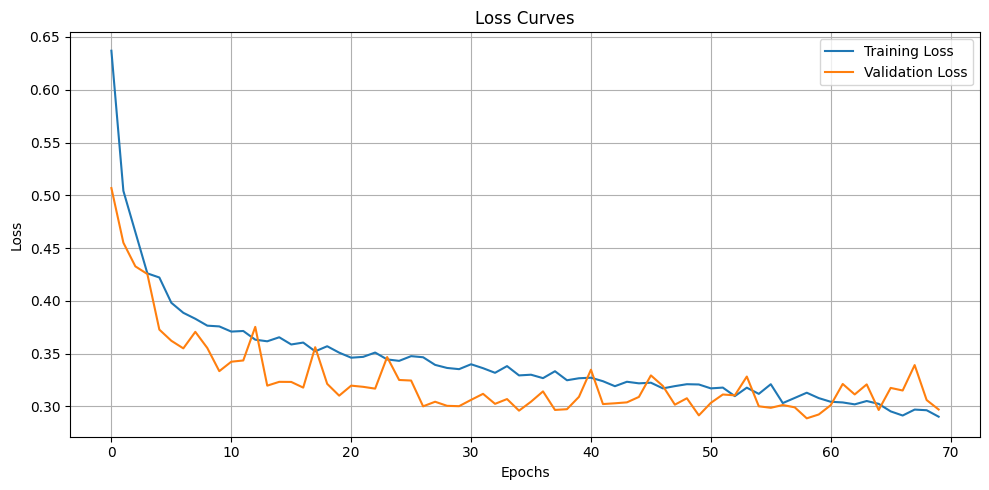

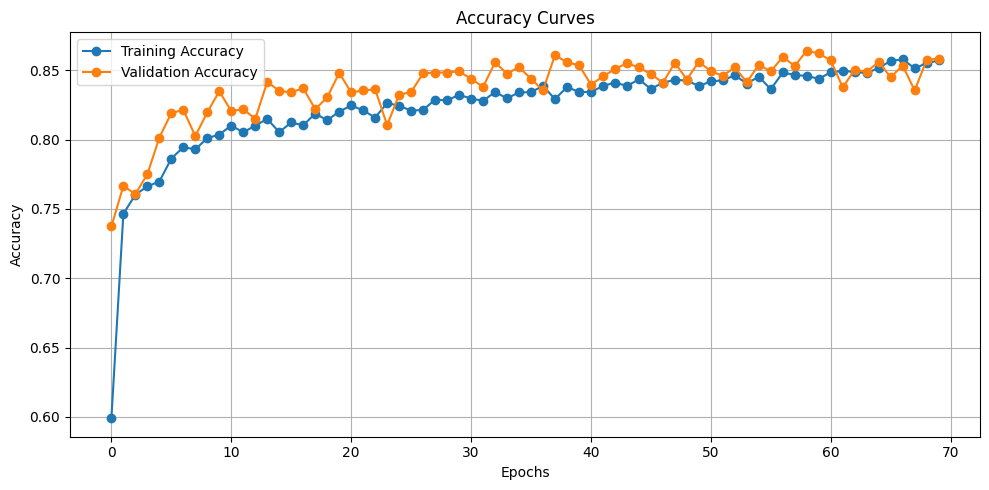

In [36]:
import matplotlib.pyplot as plt

# Assuming 'history' is the History object returned by model1.fit()

# Plotting Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 749ms/step


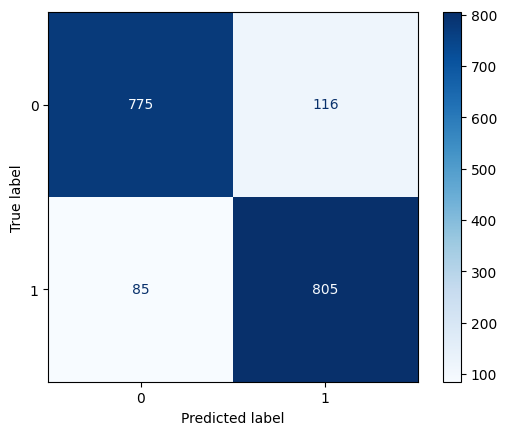

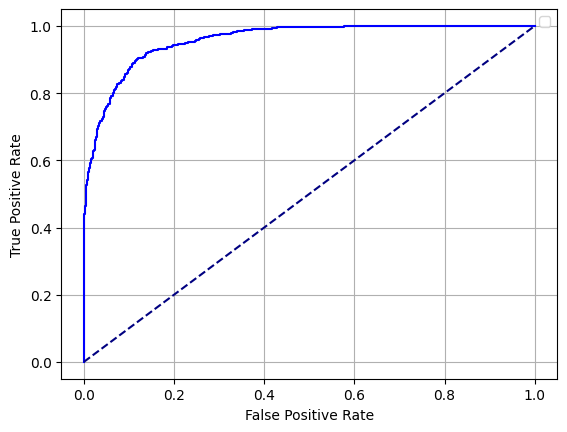

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from tensorflow.keras.models import load_model


output_dir = "plots-2"
os.makedirs(output_dir, exist_ok=True)
# Get predictions
y_pred_probs = model1.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)  # For multi-class
y_true = test_generator.classes             # True labels

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap='Blues')
# plt.title("Confusion Matrix")
plt.show()

# ROC Curve (for binary classification)
if y_pred_probs.shape[1] == 2:  # Binary classification
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='blue') #, label=f'ROC curve (AUC = {roc_auc:.2f})'
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # plt.title('Receiver Operating Characteristic')
    plt.legend()
    plt.grid()
    plt.savefig(os.path.join(output_dir, 'roc_curve_binaryclassification.png'), dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("ROC curve plotting is currently only supported for binary classification.")

In [32]:
from sklearn.metrics import classification_report
import numpy as np

# Step 1: Get true labels
y_true = test_generator.classes  # works if test_generator is a DirectoryIterator or similar

# Step 2: Get predicted probabilities
y_pred_probs = model1.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Step 3: Get class labels (optional but helpful)
class_labels = list(test_generator.class_indices.keys())

# Step 4: Print the report
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 739ms/step
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       891
           1       0.87      0.90      0.89       890

    accuracy                           0.89      1781
   macro avg       0.89      0.89      0.89      1781
weighted avg       0.89      0.89      0.89      1781



In [34]:
y_pred_prob = model1.predict(test_generator)  # Shape: (num_samples, 2)
y_true = test_generator.classes                # True labels
y_pred = np.argmax(y_pred_prob, axis=1)        # Predicted labels

# Step 4: Use positive class probabilities (malignant = 1)
positive_class_probs = y_pred_prob[:, 1]

# Step 5: Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, positive_class_probs)

# Step 6: Save to Excel
roc_df = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr,
    'Thresholds': thresholds
})

# Save the DataFrame to Excel
roc_df.to_excel("tpr_fpr_values.xlsx", index=False)

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 740ms/step


In [ ]:
Y_true = test_generator.classes
print(f"True labels length: {len(Y_true)}")  # Should print 1781
print(f"Predicted probabilities length: {len(Y_pred_prob)}")  # Check length


In [ ]:
Y_pred_prob = Y_pred_prob[:len(Y_true)]  # Ensure the predicted probabilities match the number of true labels
print(f"Sliced predicted probabilities length: {len(Y_pred_prob)}")  # Should print 1781
Y_pred_class = (Y_pred_prob > 0.5).astype(int)  # Assuming binary classification
print(f"Final predicted labels length: {len(Y_pred_class)}")  # Should print 1781


In [ ]:
steps = int(np.ceil(test_generator.samples / test_generator.batch_size))


In [ ]:
import numpy as np
steps = int(np.ceil(test_generator.samples / test_generator.batch_size))

# Get predictions
Y_pred_prob = model1.predict(test_generator, steps=steps, verbose=1)

# Trim predictions to match actual number of samples
Y_pred_prob = Y_pred_prob[:test_generator.samples].flatten()
Y_pred_class = (Y_pred_prob > 0.5).astype(int)


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Y_true = test_generator.classes  # Should be of length 1781

cm = confusion_matrix(Y_true, Y_pred_class)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
# plt.title('Confusion Matrix')
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Step 1: Get true labels and predicted probabilities
Y_true = test_generator.classes
class_indices = test_generator.class_indices
class_labels = list(class_indices.keys())

# Get predictions (probabilities)
Y_pred_prob = model1.predict(test_generator, verbose=1)

# If it's binary classification, get class labels directly
if Y_pred_prob.shape[1] == 1:
    Y_pred_class = (Y_pred_prob > 0.5).astype(int).flatten()
else:
    Y_pred_class = np.argmax(Y_pred_prob, axis=1)

# Step 2: Confusion matrix
cm = confusion_matrix(Y_true, Y_pred_class)
print("Confusion Matrix:")
print(cm)

# Optional: Classification report
print("\nClassification Report:")
print(classification_report(Y_true, Y_pred_class, target_names=class_labels))

# Step 3: ROC Curve (for each class if multi-class)
Y_true_bin = label_binarize(Y_true, classes=range(len(class_labels)))

plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(Y_true_bin[:, i], Y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()
        

In [ ]:
from PIL import Image
import numpy as np

# Define target size (change based on your model input)
target_size = (200, 150)

# Load and preprocess all test images
X_test_processed = []

for path in X_test:
    img = Image.open(path).convert('RGB')            # Load and ensure 3 channels
    img = img.resize(target_size)                    # Resize
    img_array = np.array(img).astype(np.float32)     # Convert to array
    img_array /= 255.0                               # Normalize (if your model expects this)
    X_test_processed.append(img_array)

# Stack into final array
X_test_processed = np.stack(X_test_processed)


In [ ]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Get true labels
y_true = test_generator.classes

# Get predicted labels
y_pred = model1.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()  # Convert to binary labels (0 or 1)

# Get class names
target_names = list(test_generator.class_indices.keys())
print("Class Names:", target_names)

# Generate classification report
report = classification_report(y_true, y_pred_classes, target_names=target_names, output_dict=True)

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=target_names))

# Compute class-wise precision, recall, and F1-score
print("\nClass-wise Metrics (as percentages):")
for class_name, metrics in report.items():
    if isinstance(metrics, dict):  # Ignore 'accuracy' key in report
        precision = int(metrics['precision'] * 100)
        recall = int(metrics['recall'] * 100)
        f1_score = int(metrics['f1-score'] * 100)
        print(f"{class_name}: Precision = {precision}%, Recall = {recall}%, F1-score = {f1_score}%")


In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Ensure shuffle=False in your test_generator
steps = int(np.ceil(test_generator.samples / test_generator.batch_size))

# Predictions
y_pred_probs = model1.predict(test_generator, steps=steps, verbose=1)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = test_generator.classes

# Check matching length
assert len(y_true) == len(y_pred_classes), "Mismatch in prediction and true labels length."

# Labels
target_names = list(test_generator.class_indices.keys())

# Report
print(classification_report(y_true, y_pred_classes, target_names=target_names))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE
import tensorflow as tf

def plot_loss_curves(history):
    plt.figure(figsize=(12, 4))
    epochs = range(1, len(history.history['loss']) + 1)
    
    plt.plot(epochs, history.history['loss'], 'b-', label='Training Loss', linewidth=2)
    plt.plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    
    plt.title('Model Loss Over Training', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
plot_loss_curves(history)

In [ ]:
from tensorflow.keras.models import load_model
model1 = load_model('binary_cascading_nv.keras')

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define model using Functional API
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = Conv2D(32, (11, 11), activation='relu')(inputs)
x = MaxPooling2D(pool_size=(4, 4))(x)

x = Conv2D(64, (7, 7), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, (5, 5), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', name='last_conv')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

outputs = Dense(2, activation='softmax')(x)

# Final model
model1 = Model(inputs=inputs, outputs=outputs)
model1.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# 👇 Optional: load trained weights if already saved
# model1.load_weights("binary_cascading_nv.keras")

# Embedding model from last conv layer
embedding_model = Model(inputs=model1.input, outputs=model1.get_layer("last_conv").output)

# Run a batch through and extract embeddings
X_batch, y_batch = next(validation_generator)
embeddings = embedding_model.predict(X_batch)
embeddings_flat = embeddings.reshape(embeddings.shape[0], -1)

print("✅ Embeddings shape:", embeddings_flat.shape)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 🔹 Load your embeddings.csv
df = pd.read_csv('embeddings.csv')

# 🔸 Separate embeddings and labels
X = df.drop('true_label', axis=1).values
y = df['true_label'].values

# Optional: scale for better t-SNE/PCA performance
X_scaled = StandardScaler().fit_transform(X)

# 🔍 PCA Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.7)
plt.title("PCA of Embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Class")
plt.grid(True)
plt.show()

# 🔍 t-SNE Visualization
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='coolwarm', alpha=0.7)
plt.title("t-SNE of Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(label="Class")
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 🔹 Load embeddings
df = pd.read_csv('embeddings.csv')

# Rename last column to 'true_label' if needed
if 'true_label' not in df.columns:
    df.columns = list(range(df.shape[1]-1)) + ['true_label']

# 🔸 Separate features and labels
X = df.drop('true_label', axis=1).values
y = df['true_label'].values

# ✅ 1. PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# ✅ 2. t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

# 🎨 Plotting function
def plot_embedding(X_reduced, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='coolwarm', alpha=0.6)
    plt.legend(*scatter.legend_elements(), title="Class")
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()

# 📊 Visualizations
plot_embedding(X_pca, "PCA of Embeddings")
plot_embedding(X_tsne, "t-SNE of Embeddings")


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_flat)

plt.figure(figsize=(8,6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=np.argmax(y_batch, axis=1), cmap='coolwarm', alpha=0.7)
plt.title("t-SNE of Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Class")
plt.grid(True)
plt.show()


In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_flat)


In [ ]:
import pandas as pd

df = pd.DataFrame(embeddings_flat)
df['true_label'] = np.argmax(y_batch, axis=1)
df.to_csv("embeddings.csv", index=False)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select a few features for demonstration (you can expand this list)
features = ['f1', 'f2', 'f3', 'f4']

plt.figure(figsize=(14, 8))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='Class', y=feature, data=df, palette='coolwarm')  # use the actual label column name
    plt.title(f'{feature} by Class')
    plt.xlabel('Class')
    plt.ylabel('Value')

plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import ttest_ind

class0_embeds = embeddings_flat[np.argmax(y_batch, axis=1) == 0]
class1_embeds = embeddings_flat[np.argmax(y_batch, axis=1) == 1]

t_stat, p_val = ttest_ind(class0_embeds, class1_embeds, axis=0, equal_var=False)

print(f"Mean p-value: {np.mean(p_val):.4f}")
print(f"Significant features (p < 0.05): {np.sum(p_val > 0.05)} / {p_val.shape[0]}")


In [ ]:
class0_avg = np.mean(class0_embeds, axis=0)
class1_avg = np.mean(class1_embeds, axis=0)

print("Class 0 average (first 5 dims):", class0_avg[:5])
print("Class 1 average (first 5 dims):", class1_avg[:5])

In [ ]:
black_pixel_ratios = np.mean(np.all(X_batch == 0, axis=-1), axis=(1, 2))
print("Avg % of black pixels per image:", np.mean(black_pixel_ratios) * 100)


In [ ]:
import numpy as np

# Step 1: Convert batch to grayscale
X_gray = np.mean(X_batch, axis=-1)  # (batch_size, height, width)

# Step 2: Count black pixels per image
black_pixel_counts = np.sum(X_gray == 0, axis=(1, 2))  # total black pixels per image
total_pixels = X_gray.shape[1] * X_gray.shape[2]
black_pixel_percentages = (black_pixel_counts / total_pixels) * 100

# Step 3: Split based on class
class_indices = np.argmax(y_batch, axis=1)  # Assuming one-hot labels

class0_percentages = black_pixel_percentages[class_indices == 0]
class1_percentages = black_pixel_percentages[class_indices == 1]

# Step 4: Print results
print(f"📊 Class 0 - Avg % Black Pixels: {np.mean(class0_percentages):.2f}")
print(f"📊 Class 1 - Avg % Black Pixels: {np.mean(class1_percentages):.2f}")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Fetch one batch from validation generator
X_val_batch, y_val_batch = next(validation_generator)

# Get class 1 indices
class1_indices = np.where(np.argmax(y_val_batch, axis=1) == 1)[0]

# Function to compute % black pixels in each image
def black_pixel_ratio(img):
    return np.mean(np.all(img == 0, axis=-1)) * 100

# Compute black pixel % for each class 1 image
black_ratios = [(idx, black_pixel_ratio(X_val_batch[idx])) for idx in class1_indices]

# Sort by highest black pixel %
black_ratios.sort(key=lambda x: x[1], reverse=True)

# Plot top 6 images with most black pixels
plt.figure(figsize=(15, 8))
for i, (idx, ratio) in enumerate(black_ratios[:6]):
    plt.subplot(2, 3, i + 1)
    plt.imshow(X_val_batch[idx])
    plt.title(f"Black %: {ratio:.2f}%")
    plt.axis('off')
plt.suptitle("Top Class 1 Images with Highest % Black Pixels", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import numpy as np

# Choose a conv layer to visualize (e.g., layer 0 or any Conv2D)
layer_index = 0
conv_layer = model1.layers[layer_index]

# Build a model that outputs feature maps from that layer
feature_extractor = Model(inputs=model1.input, outputs=conv_layer.output)

# Pick a sample image from Class 0 and Class 1
class0_img = X_batch[np.argmax(y_batch, axis=1) == 0][0]
class1_img = X_batch[np.argmax(y_batch, axis=1) == 1][0]

# Expand dims if needed
class0_img = np.expand_dims(class0_img, axis=0)
class1_img = np.expand_dims(class1_img, axis=0)

# Get feature maps
feature_maps_0 = feature_extractor.predict(class0_img)
feature_maps_1 = feature_extractor.predict(class1_img)

# Function to plot
def plot_feature_maps(feature_maps, title):
    n_filters = feature_maps.shape[-1]
    plt.figure(figsize=(15, 5))
    for i in range(min(n_filters, 8)):
        plt.subplot(1, 8, i+1)
        plt.imshow(feature_maps[0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()

# Plot
plot_feature_maps(feature_maps_0, "Class 0 - Feature Maps")
plot_feature_maps(feature_maps_1, "Class 1 - Feature Maps")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from matplotlib.backends.backend_pdf import PdfPages
import os

def visualize_feature_maps_pdf(model, X_batch, y_batch, pdf_path='feature_maps.pdf',
                               class_names=["Class 0", "Class 1"],
                               layer_indices=[0, 2, 4, 6],
                               samples_per_class=1, filters_to_show=6):
    """
    Saves feature maps of selected CNN layers into a PDF for each class.
    """
    if y_batch.ndim == 2:
        y_batch = np.argmax(y_batch, axis=1)

    os.makedirs(os.path.dirname(pdf_path) or ".", exist_ok=True)

    with PdfPages(pdf_path) as pdf:
        for layer_index in layer_indices:
            conv_layer = model.layers[layer_index]
            feature_model = Model(inputs=model.input, outputs=conv_layer.output)

            print(f"\n🔍 Layer {layer_index}: {conv_layer.name}")

            for class_id in np.unique(y_batch):
                class_images = X_batch[y_batch == class_id]
                print(f"🖼️ Class {class_names[class_id]} - {min(samples_per_class, len(class_images))} sample(s)")

                for i in range(min(samples_per_class, len(class_images))):
                    img = np.expand_dims(class_images[i], axis=0)
                    feature_maps = feature_model.predict(img)

                    # Plotting
                    plt.figure(figsize=(15, 3))
                    for j in range(min(filters_to_show, feature_maps.shape[-1])):
                        plt.subplot(1, filters_to_show, j + 1)
                        plt.imshow(feature_maps[0, :, :, j], cmap='viridis')
                        plt.axis('off')
                    plt.suptitle(f"{class_names[class_id]} - Sample {i+1} - Layer {layer_index}: {conv_layer.name}",
                                 fontsize=14)
                    plt.tight_layout()

                    # Save to PDF
                    pdf.savefig()
                    plt.close()

    print(f"\n✅ Feature maps saved to PDF: {os.path.abspath(pdf_path)}")


# 🔄 Example usage
# Replace these with your actual model and data variables
# model1 = ...           # Your trained CNN model
# X_batch = ...          # Batch of images (e.g. from validation generator)
# y_batch = ...          # Corresponding labels (one-hot or int)
visualize_feature_maps_pdf(
    model=model1,
    X_batch=X_batch,
    y_batch=y_batch,
    pdf_path="feature_maps.pdf",  # You can change to any path
    class_names=["Benign", "Malignant"],
    layer_indices=[0, 2, 4, 6],   # Modify depending on your model
    samples_per_class=1,
    filters_to_show=6
)


In [ ]:
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt

# 🔹 Load your embeddings CSV
df = pd.read_csv('embeddings.csv')

# ✅ Rename 'label' or whatever column is your class to 'class'
if 'label' in df.columns:
    df.rename(columns={'label': 'class'}, inplace=True)
elif 'true_label' in df.columns:
    df.rename(columns={'true_label': 'class'}, inplace=True)

# 🔍 Pick a specific feature (e.g., dimension 0 of embedding)
df_melted = df.melt(id_vars=['class'], var_name='feature', value_name='value')

# Perform Tukey's HSD test for one or more features
results = pairwise_tukeyhsd(endog=df_melted['value'],
                            groups=df_melted['class'],
                            alpha=0.05)

# 📄 Print result summary
print(results.summary())

# 📊 Optional: plot
results.plot_simultaneous()
plt.title("Tukey's HSD Test Results")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd


df = pd.read_csv("embeddings.csv")  # Update path if needed
X = df.drop(columns=["true_label"])  # shape (300, 2304)
y = df["true_label"].values

# Store significant features
significant_features = []
p_values = []

# Run Tukey HSD for each feature
for i in range(X.shape[1]):
    data = X.iloc[:, i]
    tukey = pairwise_tukeyhsd(endog=data, groups=y, alpha=0.05)
    p_val = tukey.pvalues[0]
    p_values.append(p_val)
    if p_val < 0.05:
        significant_features.append(i)

# Convert to numpy array
p_values = np.array(p_values)

# Print stats
print(f"✅ Significant features (p < 0.05): {len(significant_features)} / {X.shape[1]}")

# Plot 1: P-values of all features
plt.figure(figsize=(12, 4))
plt.plot(p_values, marker='.', linestyle='none')
plt.axhline(0.05, color='r', linestyle='--', label='p = 0.05')
plt.title("P-values across all embedding features")
plt.xlabel("Feature Index")
plt.ylabel("P-value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Heatmap of top-N discriminative features
top_n = 30
top_features = np.argsort(p_values)[:top_n]

plt.figure(figsize=(12, 6))
sns.heatmap(X.iloc[:, top_features].transpose(), cmap='coolwarm', center=0, cbar=True)
plt.title(f"Top {top_n} Most Discriminative Features (Heatmap of Embeddings)")
plt.xlabel("Samples")
plt.ylabel("Feature Index")
plt.tight_layout()
plt.show()


In [ ]:
# Save the trained model
model1.save("binary_cascading_nv.keras")
print("✅ Model saved successfully!")


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

# Define an explicit input layer
inp = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Rebuild the model architecture (same as your Sequential model)
x = Conv2D(32, (11, 11), activation='relu')(inp)
x = MaxPooling2D(pool_size=(4, 4))(x)

x = Conv2D(64, (7, 7), activation='tanh')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, (5, 5), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, (3, 3), activation='tanh')(x)

x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

out = Dense(1, activation='sigmoid')(x)

# Create the Functional model
functional_model = Model(inputs=inp, outputs=out)

# Print the model summary to confirm the architecture
functional_model.summary()


In [ ]:
functional_model.load_weights("binary_cascading_nv.keras")
print("✅ Functional model loaded with trained weights!")


In [ ]:
import numpy as np

dummy_input = np.random.rand(1, IMG_HEIGHT, IMG_WIDTH, 3).astype(np.float32)
_ = functional_model.predict(dummy_input, verbose=0)
print("✅ Functional model activated with dummy input!")


In [ ]:
def plot_layer_tsne(model, layer_name, test_generator, perplexity=30):
    """
    Extracts activations from a given layer and applies t-SNE for visualization.
    Skips layers if the extracted feature dimension is less than 2.
    """
    print(f"🔹 Processing layer: {layer_name}")
    
    # Create a model to extract activations from the specified layer
    try:
        layer_output = model.get_layer(layer_name).output
        activation_model = tf.keras.Model(inputs=model.input, outputs=layer_output)
    except ValueError as e:
        print(f"❌ Skipping layer '{layer_name}': {e}")
        return

    features, labels = [], []
    
    # Collect features from several batches of test data
    num_batches_to_collect = 20  # Adjust as needed
    batch_count = 0
    for batch_x, batch_y in test_generator:
        activations = activation_model.predict(batch_x, verbose=0)
        features.append(activations.reshape(activations.shape[0], -1))
        labels.append(batch_y)
        batch_count += 1
        if batch_count >= num_batches_to_collect:
            break

    features = np.vstack(features)
    labels = np.concatenate(labels)
    
    # Check number of samples
    if features.shape[0] < 2:
        print(f"❌ Not enough samples for t-SNE in layer {layer_name}: got {features.shape[0]} samples.")
        return

    # Check if feature dimension is at least 2
    if features.shape[1] < 2:
        print(f"❌ Skipping layer {layer_name}: feature dimension is {features.shape[1]} (needs to be >=2).")
        return

    print(f"✅ Extracted {features.shape[0]} feature vectors with {features.shape[1]} dimensions for layer: {layer_name}")
    
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    adjusted_perplexity = min(perplexity, features.shape[0] - 1)
    tsne = TSNE(n_components=2, perplexity=adjusted_perplexity, n_iter=1000, random_state=42)
    tsne_results = tsne.fit_transform(features)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter)
    plt.title(f't-SNE Visualization of {layer_name}')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.tight_layout()
    plt.show()
